In [11]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path

In [12]:
# open cleaned_weight_measurements.pkl
with open('cleaned_weight_measurements.pkl', 'rb') as f:
    df = pickle.load(f)

In [13]:
# remove columns 2 to 5
df = df.drop(df.columns[1:5], axis=1)

In [14]:
# is any of the weight values a string?
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        # convert to numeric, forcing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [15]:
# make all values relative to the second columns, except for the first column
# df.iloc[:, 1:] = df.iloc[:, 1:].div(df.iloc[:, 1], axis=0) * 100

In [16]:
# melt the dataframe to have three columns: 'name', 'date', and 'weight'
melted_df = df.melt(id_vars=["Name"], var_name="Date", value_name="weight")
# convert 'Date' to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y-%m-%d')
# rename 'Name' to 'subject'
melted_df.rename(columns={'Name': 'subject', "Date": 'date'}, inplace=True)

In [17]:

# load events and sessions summary
local_path = Path(utils.get_outpath()) / Path("visual_and_COT_data")
utils.rsync_cluster_data(
    project_name="visual_and_COT_data",
    file_path='sessions_summary.csv',
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# read it
sessions_summary = pd.read_csv(local_path / Path('sessions_summary.csv'), sep=';')

receiving incremental file list
sessions_summary.csv

sent 19,867 bytes  received 34,445 bytes  21,724.80 bytes/sec
total size is 11,799,428  speedup is 217.25


In [18]:
sessions_summary = dft.add_day_column_to_df(sessions_summary)
# make it a daytime value
sessions_summary["year_month_day"] = pd.to_datetime(sessions_summary['year_month_day'], format='%Y-%m-%d')
sessions_summary = sessions_summary.groupby(['subject', 'year_month_day']).agg({
    'weight': 'median',
}).reset_index()
# #rename columns
sessions_summary.rename(columns={'year_month_day': 'date'}, inplace=True)

In [19]:
# add the data from automatic weighting from the 16th of July 2025
sessions_summary = sessions_summary[sessions_summary['date'] >= '2025-07-16']
melted_df = pd.concat([melted_df, sessions_summary], ignore_index=True)

In [20]:
melted_df

,subject,date,weight
0,ACV001,2025-03-10,22.160
1,ACV002,2025-03-10,25.610
2,ACV003,2025-03-10,24.100
3,ACV004,2025-03-10,27.190
4,ACV005,2025-03-10,26.400
...,...,...,...
1401,ACV010,2025-09-19,23.850
1402,ACV010,2025-09-20,26.270
1403,ACV010,2025-09-21,24.110
1404,ACV010,2025-09-22,25.605


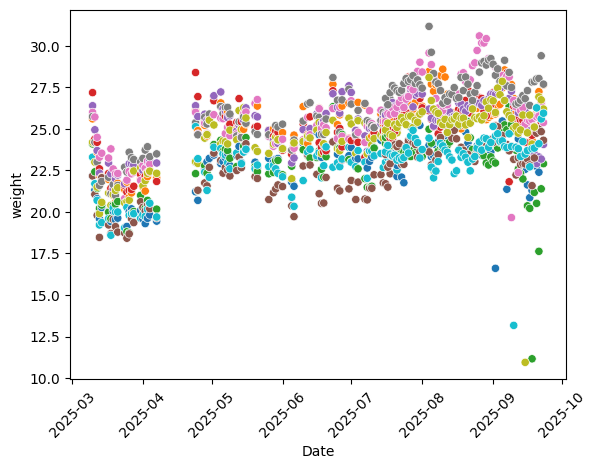

In [21]:
sns.scatterplot(data=melted_df, x='date', y='weight', hue='subject')
plt.xticks(rotation=45)
plt.xlabel('Date')
# remove legend
plt.legend([], [], frameon=False)

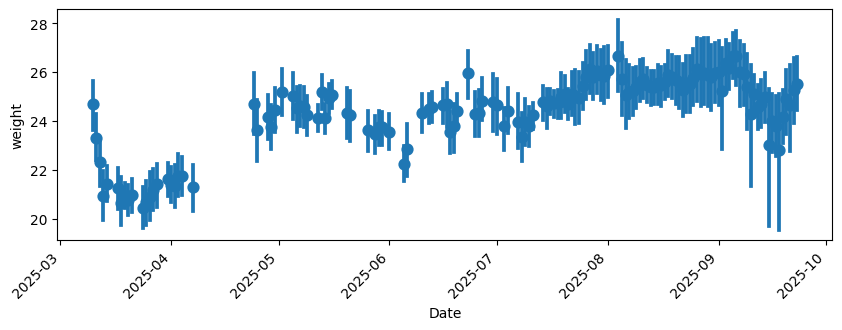

In [22]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.pointplot(data=melted_df, x='date', y='weight', native_scale= True, linestyles="")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')

# save figure as .pdf
plt.savefig('figures/hmv_weight_over_time.pdf', bbox_inches='tight', transparent=True)


/tmp/ipykernel_539183/446614914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff() / filtered_df.groupby('subject')['weight'].shift(1)
/tmp/ipykernel_539183/446614914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days


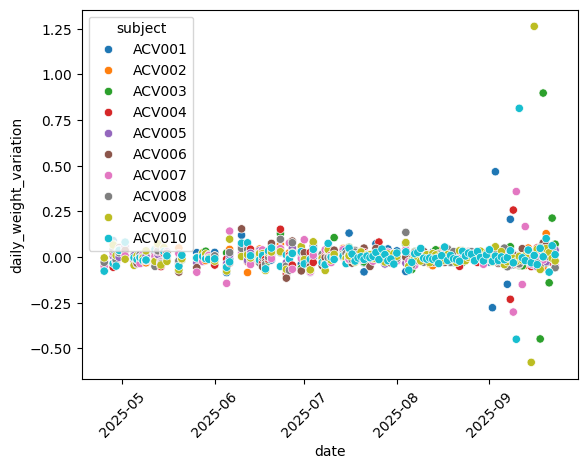

In [27]:
# explore the relationship between how much weight variation has been from day to day, and how much water they drank in the task between these times.
# restrict the analysis to the data from the 15th of march to the 15th of April
start_date = pd.to_datetime('2025-04-15')
end_date = pd.to_datetime('2025-09-24')
filtered_df = melted_df[(melted_df['date'] >= start_date) & (melted_df['date'] <= end_date)]

# calculate the daily weight variation using the difference divided by the previous day's weight
filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff() / filtered_df.groupby('subject')['weight'].shift(1)
# calculate the time difference in days
filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days

# # restrict to rows where the time difference is 1 day
# filtered_df = filtered_df[filtered_df['time_diff_days'] == 1]
# # drop nans
# filtered_df = filtered_df.dropna()

# plot the daily weight variation against the date
sns.scatterplot(data=filtered_df, x='date', y='daily_weight_variation', hue='subject')
plt.xticks(rotation=45)
plt.show()

In [23]:
# get data on water consumption
animals = utils.get_animals_in_project("visual_and_COT_data")
animals_to_remove = ['test', 'test2']
animals = [animal for animal in animals if animal not in animals_to_remove]
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path("visual_and_COT_data") / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name="visual_and_COT_data",
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path("visual_and_COT_data") / Path("sessions") / Path(mouse)
    andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(andf)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
behavdf = pd.concat(df_list, ignore_index=True)

receiving incremental file list

sent 27 bytes  received 73 bytes  66.67 bytes/sec
total size is 511,519,982  speedup is 5,115,199.82
receiving incremental file list

sent 27 bytes  received 73 bytes  66.67 bytes/sec
total size is 461,923,623  speedup is 4,619,236.23
receiving incremental file list

sent 27 bytes  received 73 bytes  66.67 bytes/sec
total size is 504,528,726  speedup is 5,045,287.26
receiving incremental file list

sent 27 bytes  received 73 bytes  40.00 bytes/sec
total size is 420,430,364  speedup is 4,204,303.64
receiving incremental file list

sent 27 bytes  received 73 bytes  66.67 bytes/sec
total size is 382,524,187  speedup is 3,825,241.87
receiving incremental file list

sent 27 bytes  received 73 bytes  -200.00 bytes/sec
total size is 506,581,831  speedup is 5,065,818.31
receiving incremental file list

sent 27 bytes  received 73 bytes  66.67 bytes/sec
total size is 496,021,029  speedup is 4,960,210.29
receiving incremental file list

sent 27 bytes  received 73 

/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV001.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV002.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV003.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV004.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV005.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV006.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV007.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV008.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV009.


/tmp/ipykernel_539183/2670138167.py:21: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV010.
Loaded data for punish_test.


In [28]:
filtered_df['water_consumption'] = np.nan
# calculate the water consumption for each subject for each period, at 9am
for row in filtered_df.itertuples():
    subject = row.subject
    date = row.date
    time_diff_days = row.time_diff_days
    date9am = date.replace(hour=9, minute=0, second=0, microsecond=0)
    # if time_diff_days is NaN, skip this row
    if pd.isna(time_diff_days):
        continue
    previous_date9am = date9am - pd.Timedelta(days=time_diff_days)
    # get the water consumption for the subject on the date
    subject_df = behavdf[behavdf['subject'] == subject]
    # convert date column to datetime
    subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
    subject_date_df = subject_df[(subject_df['date'] >= previous_date9am) & (subject_df['date'] < date9am)]
    total_water_consumption = subject_date_df['water'].sum()
    filtered_df.loc[row.Index, 'water_consumption'] = total_water_consumption

/tmp/ipykernel_539183/1515590142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['water_consumption'] = np.nan
/tmp/ipykernel_539183/1515590142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_539183/1515590142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [29]:
filtered_df['water_consumption_normalized'] = filtered_df['water_consumption'] / filtered_df['time_diff_days']

/tmp/ipykernel_539183/3054460057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['water_consumption_normalized'] = filtered_df['water_consumption'] / filtered_df['time_diff_days']


In [30]:
# regress the water consumption against the daily weight variation
import statsmodels.api as sm
X = filtered_df['water_consumption_normalized']
y = filtered_df['daily_weight_variation']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())



                              OLS Regression Results                              
Dep. Variable:     daily_weight_variation   R-squared:                       0.013
Model:                                OLS   Adj. R-squared:                  0.012
Method:                     Least Squares   F-statistic:                     15.00
Date:                    Tue, 23 Sep 2025   Prob (F-statistic):           0.000114
Time:                            13:22:36   Log-Likelihood:                 1445.9
No. Observations:                    1167   AIC:                            -2888.
Df Residuals:                        1165   BIC:                            -2878.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_539183/2527243765.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_539183/2527243765.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


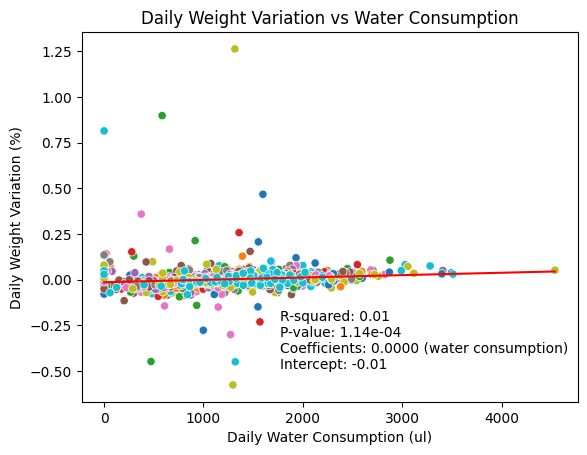

In [31]:
# plot the correlation between daily weight variation and water consumption
sns.scatterplot(data=filtered_df, x='water_consumption_normalized', y='daily_weight_variation', hue='subject')
# add a regression line using the model in the cell above
x_vals = np.linspace(filtered_df['water_consumption_normalized'].min(), filtered_df['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
# add the statistics to the plot
plt.text(0.4, 0.25, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2e}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Daily Water Consumption (ul)')
plt.ylabel('Daily Weight Variation (%)')
plt.title('Daily Weight Variation vs Water Consumption')
#remove legend
plt.legend([], [], frameon=False)
# plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_daily_weight_vs_water_consumed.pdf', bbox_inches='tight', transparent=True)

In [35]:
# compare with the citric acid consumption data
with open('cleaned_citric_acid_weight.pkl', 'rb') as f:
    df_ca = pickle.load(f)

# group the filtered_df by date
filtered_df_grouped = filtered_df.groupby('date').agg({
    'daily_weight_variation': 'mean',
    'water_consumption': 'sum',
    'time_diff_days': 'mean'
    }).reset_index()

# add the citric acid consumption data to the filtered_df_grouped
# turn the columns of df_ca into a single column
df_ca = df_ca.melt()
df_ca.columns = ['date', 'citric_acid_consumption']
# turn to positive values and add the loss of water when turning the bottle upside down
df_ca['citric_acid_consumption'] = -df_ca['citric_acid_consumption'] - 0.6
df_ca['date'] = pd.to_datetime(df_ca['date'], format='%Y-%m-%d')

# merge the two dataframes on date
df_combined = pd.merge(filtered_df_grouped, df_ca, on='date', how='left')

In [36]:
df_combined['water_consumption_normalized'] = df_combined['water_consumption'] / df_combined['time_diff_days']
df_combined['citric_acid_consumption_normalized'] = df_combined['citric_acid_consumption'] / df_combined['time_diff_days']

<Axes: xlabel='water_consumption_normalized', ylabel='citric_acid_consumption_normalized'>

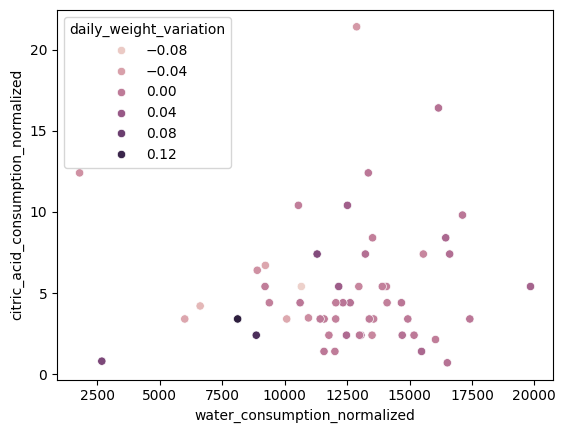

In [37]:
sns.scatterplot(data=df_combined, x='water_consumption_normalized', y='citric_acid_consumption_normalized', hue='daily_weight_variation')

In [39]:
df_combined

,date,daily_weight_variation,water_consumption,time_diff_days,citric_acid_consumption,water_consumption_normalized,citric_acid_consumption_normalized
0,2025-04-24,NaN,0.0,NaN,NaN,NaN,NaN
1,2025-04-25,-0.042641,6344.0,1.0,NaN,6344.000000,NaN
2,2025-04-28,0.024576,50254.0,3.0,NaN,16751.333333,NaN
3,2025-04-29,-0.015940,9018.0,1.0,NaN,9018.000000,NaN
4,2025-04-30,0.029369,23828.0,1.0,NaN,23828.000000,NaN
...,...,...,...,...,...,...,...
111,2025-09-19,0.105578,8862.0,1.0,2.4,8862.000000,2.4
112,2025-09-20,0.030873,12194.0,1.0,NaN,12194.000000,NaN
113,2025-09-21,-0.011760,10416.0,1.0,NaN,10416.000000,NaN
114,2025-09-22,0.031387,12514.0,1.0,10.4,12514.000000,10.4


the weird dot in 2500 of water consumption is because the task was stopped that weekend due to TV failure
the animals had normal water during that weekend. It corresponds to the 2025-06-23 date

In [40]:
# remove this point from this dataset and investigate the change of weight when animals have free access to water

dfc_cleaned = df_combined[df_combined.date != pd.to_datetime('2025-06-23')]
dfc_cleaned = dfc_cleaned.dropna(subset=['water_consumption_normalized', 'citric_acid_consumption_normalized'])
dfc_cleaned['water_consumption_normalized'] = dfc_cleaned['water_consumption_normalized'] / 1000 # in mls

# Ensure 'citric_acid_consumption_normalized' is numeric
dfc_cleaned['citric_acid_consumption_normalized'] = pd.to_numeric(dfc_cleaned['citric_acid_consumption_normalized'], errors='coerce')

import statsmodels.api as sm
X = dfc_cleaned['water_consumption_normalized']
y = dfc_cleaned['citric_acid_consumption_normalized']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())

                                    OLS Regression Results                                    
Dep. Variable:     citric_acid_consumption_normalized   R-squared:                       0.000
Model:                                            OLS   Adj. R-squared:                 -0.019
Method:                                 Least Squares   F-statistic:                   0.01583
Date:                                Tue, 23 Sep 2025   Prob (F-statistic):              0.900
Time:                                        13:31:41   Log-Likelihood:                -151.17
No. Observations:                                  55   AIC:                             306.3
Df Residuals:                                      53   BIC:                             310.4
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
                                   coef    std err

/tmp/ipykernel_539183/48493621.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_539183/48493621.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


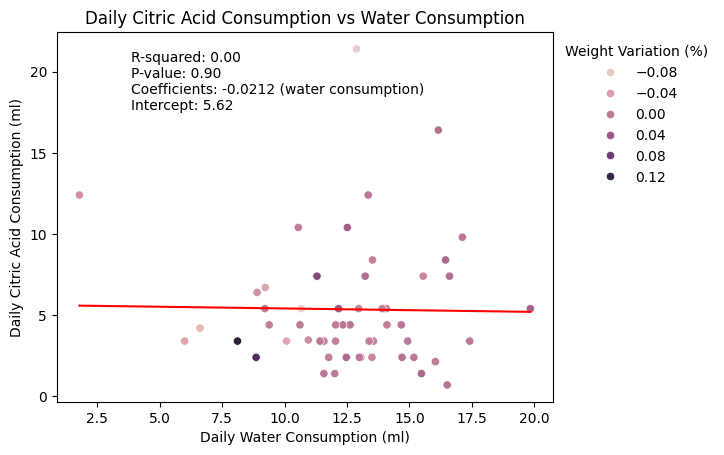

In [41]:

sns.scatterplot(data=dfc_cleaned, x='water_consumption_normalized', y='citric_acid_consumption_normalized', hue='daily_weight_variation')
# add a regression line using the model in the cell above
x_vals = np.linspace(dfc_cleaned['water_consumption_normalized'].min(), dfc_cleaned['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red')
# add the statistics to the plot
plt.text(0.15, 0.95, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2f}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Daily Water Consumption (ml)')
plt.ylabel('Daily Citric Acid Consumption (ml)')
plt.title('Daily Citric Acid Consumption vs Water Consumption')
#put the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Weight Variation (%)')
# plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_citric_acid_vs_water.pdf', bbox_inches='tight', transparent=True)


(20248.0, 20269.0)

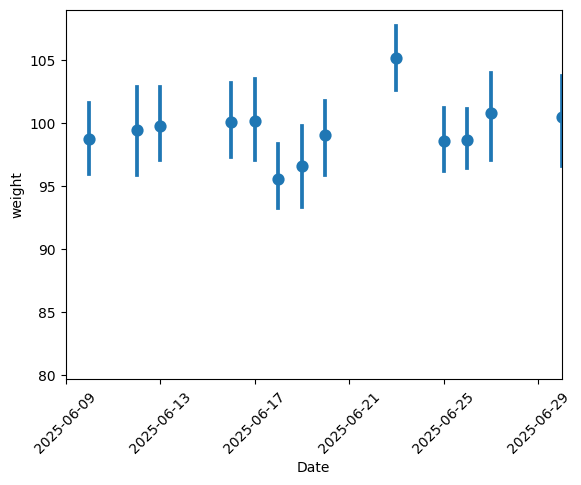

In [48]:
sns.pointplot(data=melted_df, x='date', y='weight', native_scale=True, linestyles="")
plt.xticks(rotation=45)
plt.xlabel('Date')
# remove legend
plt.legend([], [], frameon=False)

plt.xlim(pd.to_datetime('2025-06-09'), pd.to_datetime('2025-06-30'))

### How much weight variation in the previous day determines how much they drink?

In [38]:
# add the previous day's variation to filtered_df
filtered_df['previous_daily_weight_variation'] = np.nan
# calculate the previous day's daily weight variation for each subject
for row in filtered_df.itertuples():
    subject = row.subject
    date = row.date
    # get the previous day's daily weight variation for the subject
    subject_df = filtered_df[filtered_df['subject'] == subject]
    previous_date = date - pd.Timedelta(days=1)
    previous_row = subject_df[subject_df['date'] == previous_date]
    if not previous_row.empty:
        filtered_df.loc[row.Index, 'previous_daily_weight_variation'] = previous_row['daily_weight_variation'].values[0]


/tmp/ipykernel_36022/332081344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['previous_daily_weight_variation'] = np.nan


In [39]:
# regress the water consumption against the daily weight variation
import statsmodels.api as sm
X = filtered_df['water_consumption_normalized']
y = filtered_df['previous_daily_weight_variation']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     previous_daily_weight_variation   R-squared:                       0.010
Model:                                         OLS   Adj. R-squared:                  0.008
Method:                              Least Squares   F-statistic:                     6.003
Date:                             Mon, 18 Aug 2025   Prob (F-statistic):             0.0146
Time:                                     16:14:46   Log-Likelihood:                 1284.1
No. Observations:                              617   AIC:                            -2564.
Df Residuals:                                  615   BIC:                            -2555.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

/tmp/ipykernel_36022/3093701980.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_36022/3093701980.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


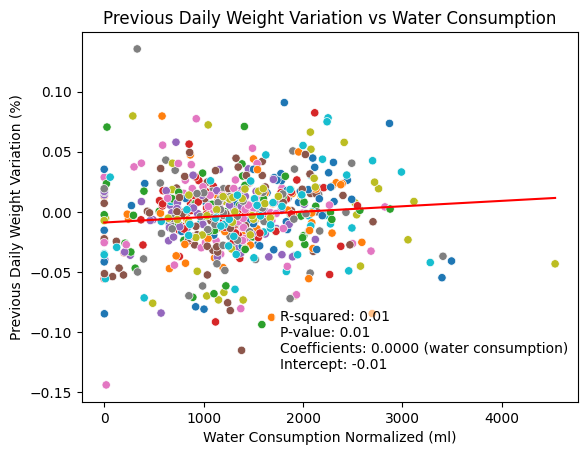

In [40]:
# plot the correlation between daily weight variation and water consumption
sns.scatterplot(data=filtered_df, x='water_consumption_normalized', y='previous_daily_weight_variation', hue='subject')
# add a regression line using the model in the cell above
x_vals = np.linspace(filtered_df['water_consumption_normalized'].min(), filtered_df['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
# add the statistics to the plot
plt.text(0.4, 0.25, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2f}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Water Consumption Normalized (ml)')
plt.ylabel('Previous Daily Weight Variation (%)')
plt.title('Previous Daily Weight Variation vs Water Consumption')
#remove legend
plt.legend([], [], frameon=False)
# plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_previous_day_weight_variation_vs_water_consumed.pdf', bbox_inches='tight', transparent=True)

Analysis of the new scale and how the weights match the manual weighting

In [19]:
# open cleaned_weight_measurements.pkl
with open('cleaned_weight_measurements.pkl', 'rb') as f:
    df = pickle.load(f)
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        # convert to numeric, forcing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
# melt the dataframe to have three columns: 'name', 'date', and 'weight'
scale_df = df.melt(id_vars=["Name"], var_name="Date", value_name="weight")
# convert 'Date' to datetime
scale_df['Date'] = pd.to_datetime(scale_df['Date'], format='%Y-%m-%d')
# rename 'Name' to 'subject'
scale_df.rename(columns={'Name': 'subject', "Date": 'date'}, inplace=True)
scale_df['type'] = 'manual'

In [20]:
# get the weight per subject per day
# load events and sessions summary
local_path = Path(utils.get_outpath()) / Path(tv_projects[1])
utils.rsync_cluster_data(
    project_name=tv_projects[1],
    file_path='sessions_summary.csv',
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# read it
sessions_summary = pd.read_csv(local_path / Path('sessions_summary.csv'), sep=';')

bind [127.0.0.1]:8050: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 8050
bind [127.0.0.1]:27001: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 27001
Could not request local forwarding.


receiving incremental file list
sessions_summary.csv

sent 17,011 bytes  received 75,884 bytes  37,158.00 bytes/sec
total size is 9,733,513  speedup is 104.78


In [21]:
sessions_summary = dft.add_day_column_to_df(sessions_summary)
# make it a daytime value
sessions_summary["year_month_day"] = pd.to_datetime(sessions_summary['year_month_day'], format='%Y-%m-%d')
sessions_summary = sessions_summary.groupby(['subject', 'year_month_day']).agg({
    'weight': 'median',
}).reset_index()
# #rename columns
sessions_summary.rename(columns={'year_month_day': 'date'}, inplace=True)
sessions_summary['type'] = 'auto'

In [24]:
# merge the two
# scale_df['date'] = scale_df['date'].dt.strftime('%Y-%m-%d')  # ensure date format matches
# concatenate the two dataframes
wdf = pd.concat([scale_df, sessions_summary], ignore_index=True)

In [25]:
# remove measurements that are ridiculously high
wdf = wdf[wdf['weight'] < 30]  # assuming weights above 100g are unrealistic

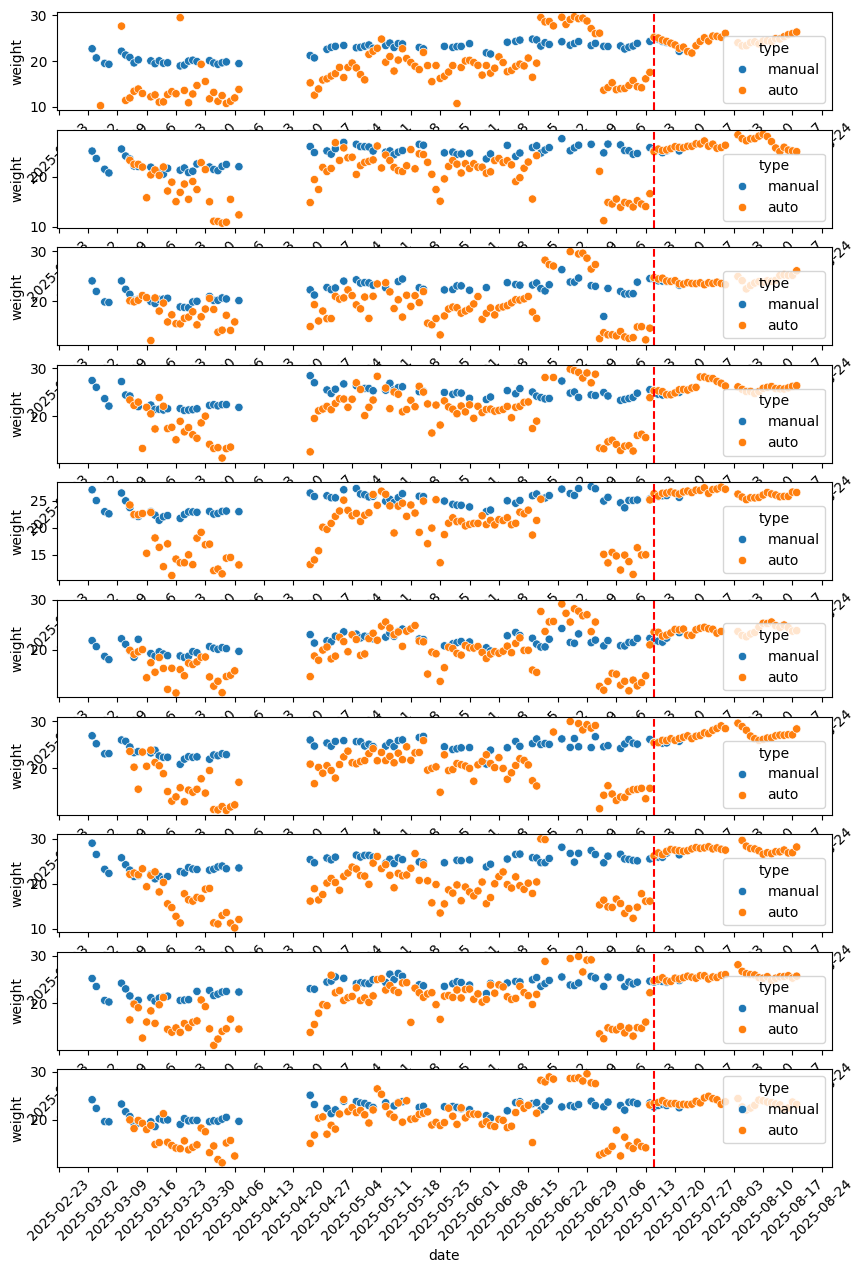

In [26]:
import matplotlib.dates as mdates
fig, axs = plt.subplots(nrows=wdf.subject.nunique(), ncols=1, figsize=(10, 15))
axs = axs.ravel()
for i, subject in enumerate(wdf.subject.unique()):
    ax = axs[i]
    subject_df = wdf[wdf['subject'] == subject]
    sns.scatterplot(data=subject_df, x='date', y='weight', hue='type', ax=ax)
    # rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Set the x-axis to show more ticks
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the ticks as dates
    # Optionally, set the interval for ticks (e.g., every 7 days)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    # vertical line at 2025-07-15
    ax.axvline(pd.to_datetime('2025-07-15'), color='red', linestyle='--')
plt.show()


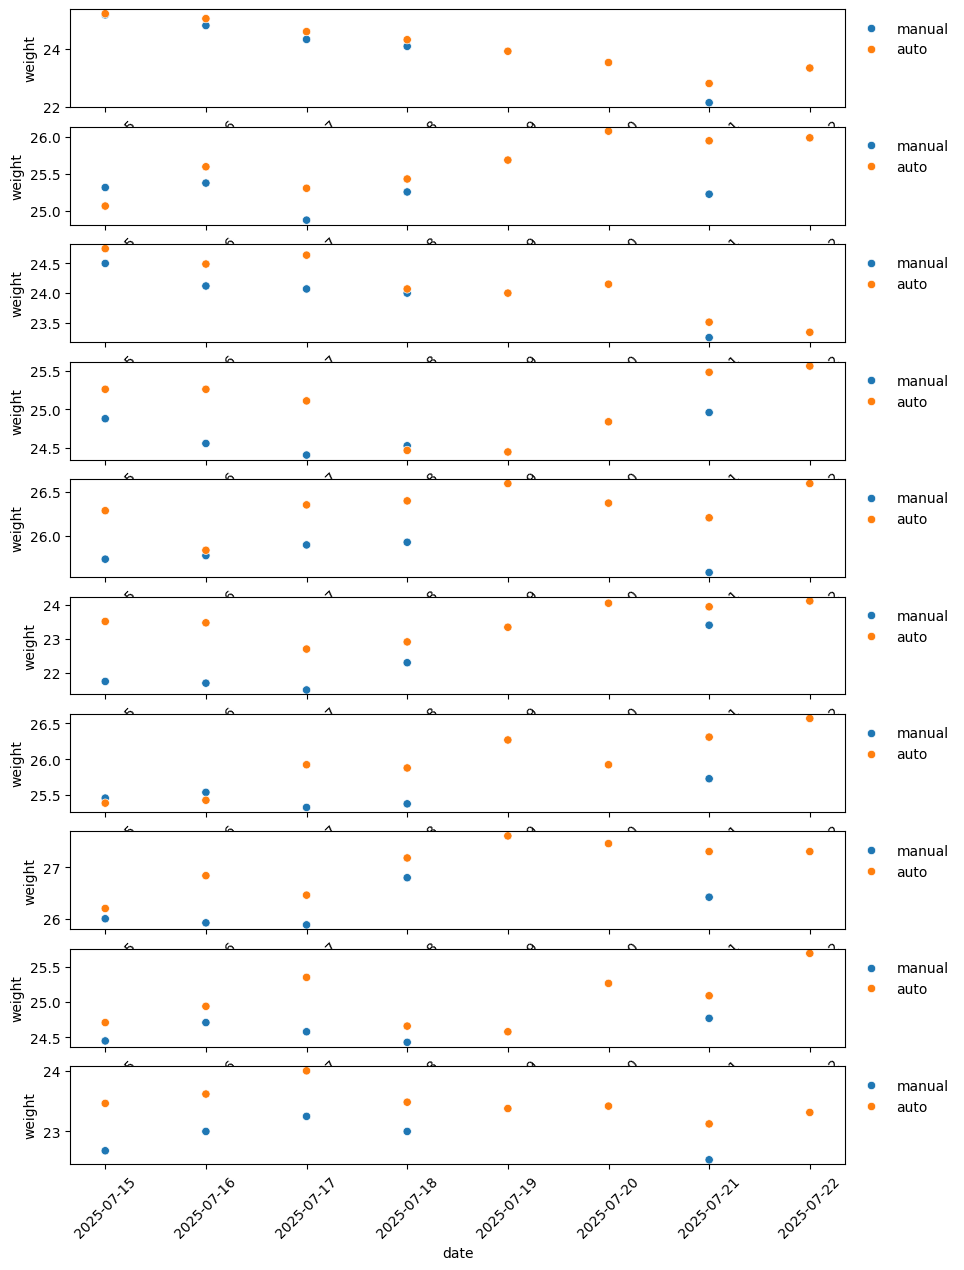

In [142]:
# do the same for just the days after fixing the scale
fig, axs = plt.subplots(nrows=wdf.subject.nunique(), ncols=1, figsize=(10, 15))
axs = axs.ravel()
for i, subject in enumerate(wdf.subject.unique()):
    ax = axs[i]
    subject_df = wdf[np.logical_and(wdf['subject'] == subject, wdf['date'] >= pd.to_datetime('2025-07-15'))]
    sns.scatterplot(data=subject_df, x='date', y='weight', hue='type', ax=ax)
    # rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Set the x-axis to show more ticks
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the ticks as dates
    # Optionally, set the interval for ticks (e.g., every 7 days)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    # legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.show()


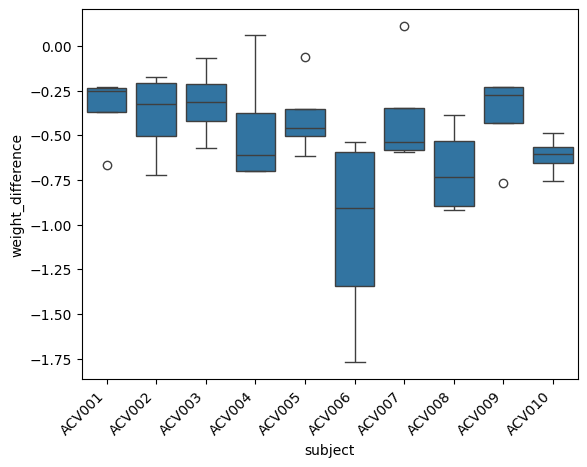

In [152]:
# show the differences
dif_df = wdf[wdf.date > pd.to_datetime('2025-07-15')]
# Pivot the table
pivoted_df = dif_df.pivot_table(
    index=['subject', 'date'],  # Keep 'subject' and 'date' as the index
    columns='type',            # Use 'type' (manual/auto) as columns
    values='weight'            # Use 'weight' as the values
).reset_index()                # Reset the index to turn it back into columns

# Rename the columns for clarity (optional)
pivoted_df.columns.name = None  # Remove the name of the columns
pivoted_df.rename(columns={'manual': 'manual_weight', 'auto': 'auto_weight'}, inplace=True)

# drop rows with nans
pivoted_df = pivoted_df.dropna(subset=['manual_weight', 'auto_weight'])

# calculate the difference
pivoted_df['weight_difference'] = pivoted_df['manual_weight'] - pivoted_df['auto_weight']

sns.boxplot(data=pivoted_df, x='subject', y='weight_difference')
plt.xticks(rotation=45, ha='right')
plt.show()